In [3]:
import os
import matplotlib

import numpy as np
import xarray as xr
import pandas as pd
import rasterio as rio
import geopandas as gp

import matplotlib.pyplot as plt
import matplotlib.animation as animation

from affine import Affine
from matplotlib import gridspec
from datetime import datetime, timedelta
from rasterio import features, mask
from IPython.display import HTML
from pandas.plotting import register_matplotlib_converters
from dateutil.relativedelta import relativedelta
# from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

register_matplotlib_converters()
matplotlib.rcParams['animation.embed_limit'] = 2**128

### Download the ssebop ET data for the cv watershed bbox, and put it in the "../data" folder

https://cida.usgs.gov/thredds/ncss/ssebopeta/monthly?var=et&north=42.432488&west=-123.097574&east=-117.980824&south=34.775165&disableProjSubset=on&horizStride=1&time_start=2000-01-01T00%3A00%3A00Z&time_end=2020-12-01T00%3A00%3A00Z&timeStride=1

https://cida.usgs.gov/thredds/ncss/ssebopeta/monthly?var=et&north=42.432488&west=-123.097574&east=-117.980824&south=34.7751&disableProjSubset=on&horizStride=1&time_start=2000-01-01T00%3A00%3A00Z&time_end=2020-10-01T00%3A00%3A00Z&timeStride=1


In [4]:
# Read the ET nc file 
files = [os.path.join("../data",x) for x in os.listdir("../data") if x.endswith("nc") if "ssebop" in x]
ds = xr.open_dataset(files[0])

In [5]:
# Extract the ET data within CV and CVWS shapefiles

cvws = gp.read_file('../shape/cvws.shp')
cv = gp.read_file('../shape/cv.shp')

In [6]:
def transform_from_latlon(lat, lon):
    lat = np.asarray(lat)
    lon = np.asarray(lon)
    trans = Affine.translation(lon[0], lat[0])
    scale = Affine.scale(lon[1] - lon[0], lat[1] - lat[0])
    return trans * scale

def rasterize(shapes, coords, fill=np.nan, **kwargs):
    """Rasterize a list of (geometry, fill_value) tuples onto the given
    xray coordinates. This only works for 1d latitude and longitude
    arrays.
    """
    transform = transform_from_latlon(coords['lat'], coords['lon'])
    out_shape = (len(coords['lat']), len(coords['lon']))
    raster = features.rasterize(shapes, out_shape=out_shape,
                                fill=fill, transform=transform,
                                dtype=float, **kwargs)
    return xr.DataArray(raster, coords=coords, dims=('lat', 'lon'))

In [7]:
ds['cvws'] = rasterize(cvws.geometry, ds['et'][0].coords)
ds['cv'] = rasterize(cv.geometry, ds['et'][0].coords)

# Is there a better way to do this? 
cvws_et = ds['et']*ds['cvws']
cv_et = ds['et']*ds['cv']

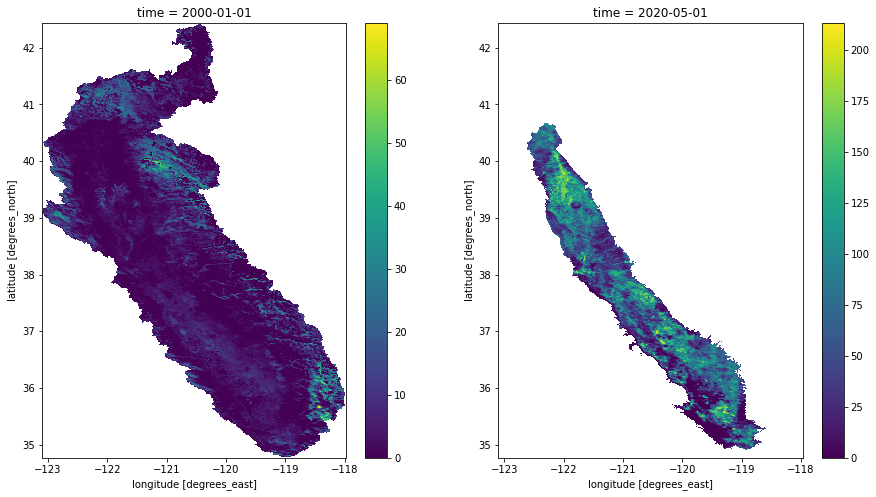

In [14]:
# Sanity check 
plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
cvws_et[0].plot()
plt.subplot(1,2,2)
cv_et[-1].plot()

In [10]:
# Get the timeseries, convert mm to km, sum all pixels to get km^3 (1x1 km pixels)

dt = pd.date_range(ds.time[0].values, ds.time[-1].values, freq = "MS")

cv_ts= []
for i in cv_et:
    cv_ts.append(i.sum()* 1e-6 )
    
cvws_ts= []
for i in cvws_et:
    cvws_ts.append(i.sum()* 1e-6 )

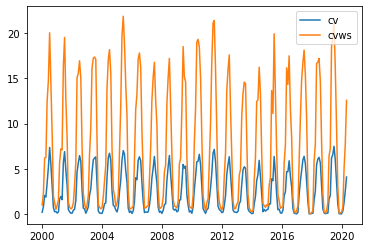

In [11]:
plt.plot(dt,np.array(cv_ts), label = "cv")
plt.plot(dt,np.array(cvws_ts), label = "cvws")
plt.legend()

In [12]:
df = pd.DataFrame({'ssebop_cv': np.array(cv_ts), "ssebop_cvws":np.array(cvws_ts)}, index = dt)
df.columns = ['ssebop_cv', "ssebop_cvws"]
df.to_csv("../data/ssebop_et.csv")

# Animations

KeyError: 0

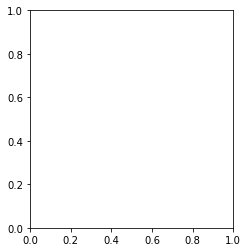

In [13]:
# Setup fig 
fig, ax1 = plt.subplots(figsize=(12,4))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2]) 
ax0 = plt.subplot(gs[0])

# get bbox of swe data
# src = rio.open("/Users/aakash/Desktop/SierraSheds/rasters/hu6_srtm_dem.tif")
imextent = cvws.bounds
lllon, lllat = imextent[0], imextent[1]
urlon, urlat = imextent[2], imextent[3]

# Initialize the basemap
m = Basemap(ax = ax0,projection='merc', ellps='WGS84',resolution='f', 
            llcrnrlon=lllon, urcrnrlon=urlon, llcrnrlat=lllat, urcrnrlat=urlat) # CVWS bbox for basemap

# Add stuff to basemap 
# m.etopo(zorder = 0)
m.shadedrelief(zorder = 0)
m.drawcoastlines(color='gray')
m.drawcountries(color='gray')
m.drawstates(color='gray')
m.drawrivers(color = "blue")
m.fillcontinents(color='none',lake_color='blue')

# Draw lines of latitude and longitude. Labels are like [left,right,top,bottom]
parallels = np.arange(0.,90.,2.)
meridians = np.arange(0.,360.,2.)

m.drawparallels(parallels,labels=[True,False,True,False]) # [left,right,top,bottom]
m.drawmeridians(meridians,labels=[True,False,False,True]) # [left,right,top,bottom]

# Plot array 
im = m.imshow(cv_et[0,:,:], cmap='gist_ncar', vmin = 0, vmax = 300)

# Set location of the colorbar
divider = make_axes_locatable(ax0)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(mappable=im, cax=cax)

######## Time Series Plot
ax1 = plt.subplot(gs[1])
line, = ax1.plot(dt,np.array(cv_ts),color='k')
ax1.set_ylabel("AET $(km^3)$")

###### Animation Functions

def animate(frame):
    im.set_array(cv_et[frame,:,:])
    ax0.set_title("SSEBop AET (mm) " + str(cv_et.coords['time'].values[frame])[:10])
    line.set_data(dt[:frame],cv_ts[:frame])

# Finally, we use the animation module to create the animation.
ani = animation.FuncAnimation(
    fig,             # figure
    animate,         # name of the function above
    frames= len(cv_et),       # Could also be iterable or list
    interval=200, # ms between frames
    repeat = True
)

HTML(ani.to_jshtml())


In [ ]:
ani.save('../images/cv_et.gif', writer='pillow')


In [ ]:
# Setup fig 
fig, ax1 = plt.subplots(figsize=(12,4))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2]) 
ax0 = plt.subplot(gs[0])

# get bbox of swe data
src = rio.open("/Users/aakash/Desktop/SierraSheds/rasters/hu6_srtm_dem.tif")
imextent = src.bounds
lllon, lllat = imextent[0], imextent[1]
urlon, urlat = imextent[2], imextent[3]

# Initialize the basemap
m = Basemap(ax = ax0,projection='merc', ellps='WGS84',resolution='f', 
            llcrnrlon=lllon, urcrnrlon=urlon, llcrnrlat=lllat, urcrnrlat=urlat) # CVWS bbox for basemap

# Add stuff to basemap 
# m.etopo(zorder = 0)
m.shadedrelief(zorder = 0)
m.drawcoastlines(color='gray')
m.drawcountries(color='gray')
m.drawstates(color='gray')
m.drawrivers(color = "blue")
m.fillcontinents(color='none',lake_color='blue')

# Draw lines of latitude and longitude. Labels are like [left,right,top,bottom]
parallels = np.arange(0.,90.,2.)
meridians = np.arange(0.,360.,2.)

m.drawparallels(parallels,labels=[True,False,True,False]) # [left,right,top,bottom]
m.drawmeridians(meridians,labels=[True,False,False,True]) # [left,right,top,bottom]

# Plot array 
im = m.imshow(cvws_et[0,:,:], cmap='gist_ncar', vmin = 0, vmax = 300)

# Set location of the colorbar
divider = make_axes_locatable(ax0)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(mappable=im, cax=cax)

######## Time Series Plot
ax1 = plt.subplot(gs[1])
line, = ax1.plot(dt,np.array(cvws_ts),color='k')
ax1.set_ylabel("AET $(km^3)$")

###### Animation Functions

def animate(frame):
    im.set_array(cvws_et[frame,:,:])
    ax0.set_title("SSEBop AET (mm) " + str(cv_et.coords['time'].values[frame])[:10])
    line.set_data(dt[:frame],cvws_ts[:frame])

# Finally, we use the animation module to create the animation.
ani = animation.FuncAnimation(
    fig,             # figure
    animate,         # name of the function above
    frames= len(cvws_ts),       # Could also be iterable or list
    interval=200, # ms between frames
    repeat = True
)

HTML(ani.to_jshtml())


In [ ]:
ani.save('../images/cvws_et.gif', writer='pillow')